In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import Xlnk, Overlay
import time

In [2]:
cornerDetection_design = Overlay("fast4.bit")


Then create DMA and Resizer IP objects.

In [3]:
dma = cornerDetection_design.axi_dma_0
corner = cornerDetection_design.fast_accel_1

In [4]:
image_path = "../clouds.jpg"
original_image = Image.open(image_path)

Image size: 800x536 pixels.


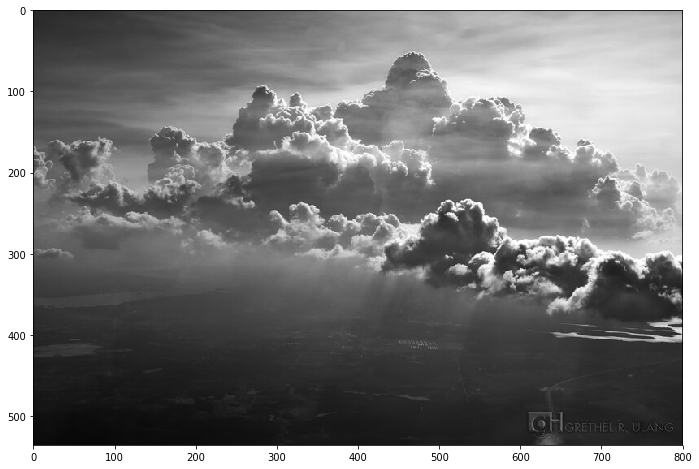

In [5]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

width, height = original_image.size
print("Image size: {}x{} pixels.".format(width, height))
_ = plt.imshow(original_image)

In [6]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(height, width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = xlnk.cma_array(shape=(height, width, 3), 
                            dtype=np.uint8, cacheable=1)

In [7]:
in_buffer[:] = np.array(original_image)

In [8]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    corner.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

We will also need to setup resizer and DMA IPs using MMIO interface 
before we stream image data to them.
For example, we need to write dimensions data to MMIO registers of resizer.
These register writings only have to be done once.

| register offset | configuration                          |
|-----------------|----------------------------------------|
| 0x10            | number of rows for picture             |
| 0x18            | number of columns for picture          |
| 0x20            | threshold                              |

In [9]:
threshold = 5
corner.write(0x10, height)
corner.write(0x18, width)
corner.write(0x20, threshold)

Now we can perform the resizing operation.

In [10]:
run_kernel()
resized_image = Image.fromarray(out_buffer)

## Display resized image

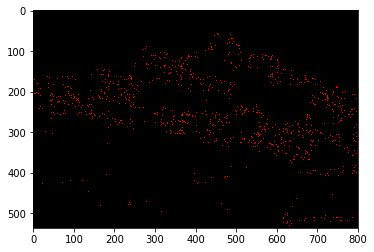

In [11]:
_ = plt.imshow(resized_image)

In [12]:
def overlay_image(image, corners, corner_size = 2):
    h = min(image.shape[0], corners.shape[0])
    w = min(image.shape[1], corners.shape[1])
    d = min(image.shape[2], corners.shape[2])
    print(h,w,d)
    new_arr = np.copy(image)
    for i in range(h):
        for j in range(w):
            if(corners[i][j][0]):
                for x in range(max(0, i-3), min(i+3, h)):
                    for y in range(max(0, j-3), min(j+3, w)):
                        new_arr[x][y][0] = 256
    
    return new_arr

In [13]:
#takes awhile
combined = overlay_image(in_buffer, out_buffer)

536 800 3


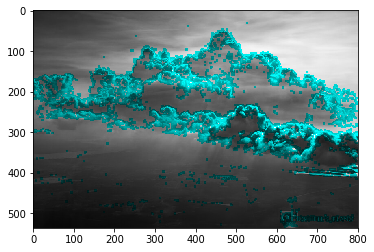

In [14]:
_ = plt.imshow(Image.fromarray(combined))

# Test Code speed on different images

In [15]:
images = [ "../clouds.jpg", "../xilinx.JPG", "../dark.jpg", "../input.jpg", "../mountain.jpeg", "../pencils.jpg", "../train.jpg", "../trees.jpg", "../marble.jpg", "../newyork.jpg"]
corners = []
sizes = []
times = []
for image in images:
    cornerDetection_design = Overlay("fast4.bit")
    dma = cornerDetection_design.axi_dma_0
    corner = cornerDetection_design.fast_accel_1
    original_image = Image.open(image)
    width, height = original_image.size
    print("Image size: {}x{} pixels.".format(width, height))

    
    xlnk = Xlnk()
    in_buffer = xlnk.cma_array(shape=(height, width, 3), 
                               dtype=np.uint8, cacheable=1)
    out_buffer = xlnk.cma_array(shape=(height, width, 3), 
                                dtype=np.uint8, cacheable=1)
    in_buffer[:] = np.array(original_image)
    
    threshold = 30
    corner.write(0x10, height)
    corner.write(0x18, width)
    corner.write(0x20, threshold)
    
    timea = time.time()
    run_kernel()
    times.append((time.time() - timea)) 
    
    
    sizes.append(width*height)
    corners.append(Image.fromarray(out_buffer))
    xlnk.xlnk_reset()

print(times)
print(sizes)

Image size: 800x536 pixels.
Image size: 200x200 pixels.
Image size: 294x171 pixels.
Image size: 1920x1080 pixels.
Image size: 500x312 pixels.
Image size: 275x183 pixels.
Image size: 1200x1200 pixels.
Image size: 3000x1687 pixels.
Image size: 512x288 pixels.
Image size: 3840x2160 pixels.
[0.01358938217163086, 0.0020782947540283203, 0.0024194717407226562, 0.06148934364318848, 0.0056056976318359375, 0.0024042129516601562, 0.0432279109954834, 0.14805030822753906, 0.005493640899658203, 0.2416231632232666]
[428800, 40000, 50274, 2073600, 156000, 50325, 1440000, 5061000, 147456, 8294400]


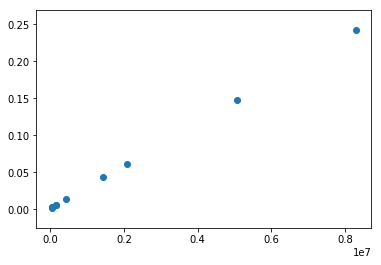

In [16]:
plt.scatter(sizes, times)
plt.show()